In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.stats as sts
import quandl
import os
from config import api_key
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

In [2]:
# Importing Quandl data using the API

In [3]:
try:
    B_Spread = quandl.get("ML/BEY", authtoken=api_key)
    Treasury_curve = quandl.get("USTREASURY/YIELD", authtoken=api_key)
    SP_500 = quandl.get("CHRIS/CME_ES2")
except Exception as e:
    print(e)

## S&P500 DataFrame

In [4]:
SP_500.reset_index(inplace=True)
SP_500

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1997-09-09,943.50,951.00,941.50,944.00,NaN,944.00,896.0,273.0
1,1997-09-10,942.75,943.25,917.00,925.00,NaN,925.00,12261.0,382.0
2,1997-09-11,924.00,929.75,910.25,918.25,NaN,918.25,9759.0,2909.0
3,1997-09-12,918.00,936.50,913.50,933.75,NaN,933.75,18496.0,4059.0
4,1997-09-15,933.50,939.75,929.00,931.50,NaN,931.50,11749.0,3818.0
...,...,...,...,...,...,...,...,...,...
5789,2020-06-09,3216.00,3220.00,3179.00,3194.50,22.25,3194.50,92923.0,127169.0
5790,2020-06-10,3194.25,3216.75,3168.75,3173.50,19.00,3175.50,160381.0,151588.0
5791,2020-06-11,3173.00,3177.75,2985.25,3003.00,176.00,2999.50,802407.0,193508.0
5792,2020-06-12,3000.75,3076.75,2971.00,3024.50,24.25,3023.75,2715442.0,414547.0


In [5]:
# Sub data frame with Settle Price only
SP500_Price_df = pd.DataFrame({'Date': SP_500['Date'],
                               'Closing Price': SP_500['Settle']
                              })
SP500_Price_df

,Date,Closing Price
0,1997-09-09,944.00
1,1997-09-10,925.00
2,1997-09-11,918.25
3,1997-09-12,933.75
4,1997-09-15,931.50
...,...,...
5789,2020-06-09,3194.50
5790,2020-06-10,3175.50
5791,2020-06-11,2999.50
5792,2020-06-12,3023.75


## Resetting B Spread dataframe 

In [6]:
B_Spread.reset_index(inplace=True)
B_Spread.columns = ['Date','B Rating']
B_Spread

,Date,B Rating
0,1996-12-31,10.01
1,1997-01-02,10.00
2,1997-01-03,10.01
3,1997-01-06,10.05
4,1997-01-07,10.07
...,...,...
6115,2020-06-08,5.99
6116,2020-06-09,6.23
6117,2020-06-10,6.34
6118,2020-06-11,6.83


In [7]:
# Convert to datetime object
B_Spread['Date'] = pd.to_datetime(B_Spread['Date'])

In [8]:
# Filter dates
New_B_Spread = B_Spread.loc[(B_Spread['Date']>='1997-09-09')]
New_B_Spread

,Date,B Rating
176,1997-09-09,9.59
177,1997-09-10,9.58
178,1997-09-11,9.60
179,1997-09-12,9.58
180,1997-09-15,9.55
...,...,...
6115,2020-06-08,5.99
6116,2020-06-09,6.23
6117,2020-06-10,6.34
6118,2020-06-11,6.83


## Treasury Curve DataFrame

In [9]:
# Resetting the index
Treasury_curve = Treasury_curve.reset_index()

In [10]:
# Converting to datetime objects 
Treasury_curve['Date'] = pd.to_datetime(Treasury_curve['Date'])
Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
0,1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1,1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
2,1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
3,1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
4,1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,2020-06-09,0.14,0.17,0.19,0.19,0.19,0.20,0.25,0.40,0.65,0.84,1.37,1.59
7615,2020-06-10,0.13,0.16,0.17,0.19,0.18,0.17,0.22,0.33,0.56,0.75,1.31,1.53
7616,2020-06-11,0.14,0.16,0.17,0.18,0.19,0.19,0.22,0.32,0.51,0.66,1.19,1.41
7617,2020-06-12,0.14,0.15,0.16,0.18,0.18,0.19,0.22,0.33,0.54,0.71,1.24,1.45


In [11]:
# Filtering the dates to match S&P500
New_Treasury_curve = Treasury_curve.loc[(Treasury_curve['Date']>='1997-09-09')]
New_Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
1924,1997-09-09,NaN,NaN,5.16,5.35,5.60,5.98,6.09,6.24,6.33,6.34,6.70,6.63
1925,1997-09-10,NaN,NaN,5.11,5.35,5.61,6.00,6.10,6.26,6.36,6.37,6.71,6.66
1926,1997-09-11,NaN,NaN,5.13,5.36,5.59,6.00,6.11,6.27,6.38,6.39,6.75,6.68
1927,1997-09-12,NaN,NaN,5.10,5.32,5.54,5.93,6.03,6.17,6.28,6.29,6.66,6.59
1928,1997-09-15,NaN,NaN,5.08,5.31,5.54,5.93,6.02,6.17,6.28,6.28,6.65,6.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,2020-06-09,0.14,0.17,0.19,0.19,0.19,0.20,0.25,0.40,0.65,0.84,1.37,1.59
7615,2020-06-10,0.13,0.16,0.17,0.19,0.18,0.17,0.22,0.33,0.56,0.75,1.31,1.53
7616,2020-06-11,0.14,0.16,0.17,0.18,0.19,0.19,0.22,0.32,0.51,0.66,1.19,1.41
7617,2020-06-12,0.14,0.15,0.16,0.18,0.18,0.19,0.22,0.33,0.54,0.71,1.24,1.45


In [12]:
# Final Treasury DataFrame
Treasury_5_Year = pd.DataFrame({'Date': New_Treasury_curve['Date'],
                                '5 Year Rate': New_Treasury_curve['5 YR']
                               })
Treasury_5_Year

,Date,5 Year Rate
1924,1997-09-09,6.24
1925,1997-09-10,6.26
1926,1997-09-11,6.27
1927,1997-09-12,6.17
1928,1997-09-15,6.17
...,...,...
7614,2020-06-09,0.40
7615,2020-06-10,0.33
7616,2020-06-11,0.32
7617,2020-06-12,0.33


## Merging DataFrames

In [13]:
SP500_BondSpread_df = pd.merge(SP500_Price_df,New_B_Spread, on='Date')

In [14]:
SP500_BondSpread_df

,Date,Closing Price,B Rating
0,1997-09-09,944.00,9.59
1,1997-09-10,925.00,9.58
2,1997-09-11,918.25,9.60
3,1997-09-12,933.75,9.58
4,1997-09-15,931.50,9.55
...,...,...,...
5778,2020-06-08,3216.75,5.99
5779,2020-06-09,3194.50,6.23
5780,2020-06-10,3175.50,6.34
5781,2020-06-11,2999.50,6.83


In [15]:
# Final DataFrame
Final_Market_Data_df = pd.merge(SP500_BondSpread_df,Treasury_5_Year,on='Date')

In [16]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate
0,1997-09-09,944.00,9.59,6.24
1,1997-09-10,925.00,9.58,6.26
2,1997-09-11,918.25,9.60,6.27
3,1997-09-12,933.75,9.58,6.17
4,1997-09-15,931.50,9.55,6.17
...,...,...,...,...
5679,2020-06-08,3216.75,5.99,0.45
5680,2020-06-09,3194.50,6.23,0.40
5681,2020-06-10,3175.50,6.34,0.33
5682,2020-06-11,2999.50,6.83,0.32


## DataFrame Calculations
- Calculate the Credit Spread (B rated yields - 5Yr Treasury Rate)
- Calculate the SP500, B rating yield and 5Yr Treasruy returns

In [17]:
# Yield Spread Calculation
Final_Market_Data_df['Yield Spread'] = Final_Market_Data_df['B Rating'] - Final_Market_Data_df['5 Year Rate']

# Calculating S&P500 Returns
Final_Market_Data_df['S&P 500 Returns'] = Final_Market_Data_df['Closing Price'].pct_change()

# Calculating Yield Spread Returns
Final_Market_Data_df['Yield Spread Returns'] = Final_Market_Data_df['Yield Spread'].pct_change()

In [18]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798
...,...,...,...,...,...,...,...
5679,2020-06-08,3216.75,5.99,0.45,5.54,0.012671,0.000000
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195


Text(0.5, 1.0, 'Junk Bond vs 5 Year Treasury Spread')

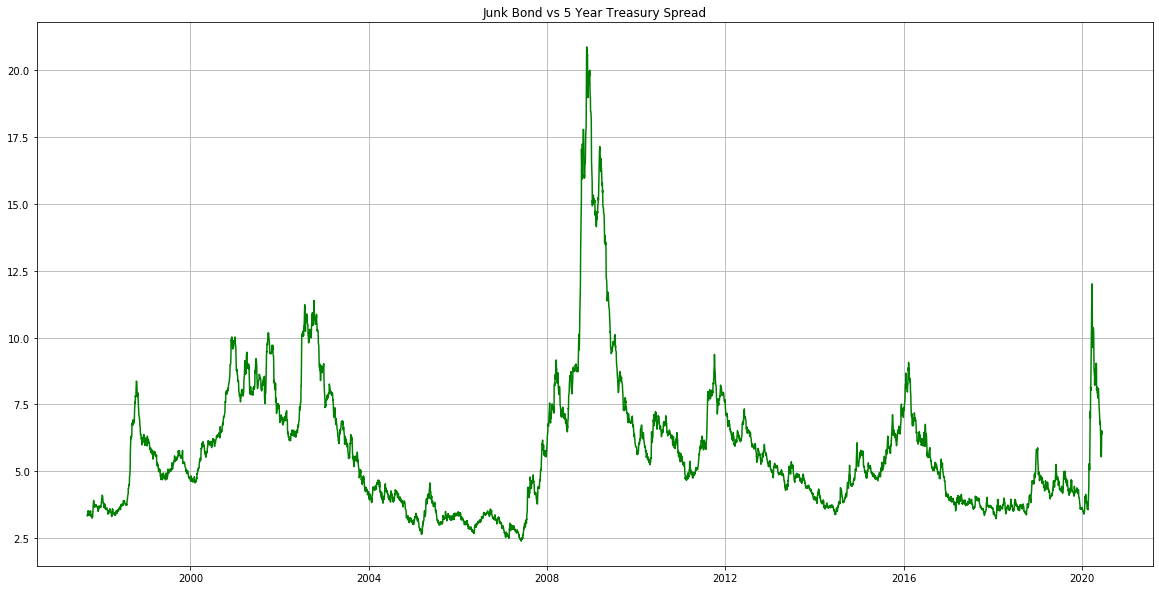

In [19]:
# Plotting the Spread
fig = plt.figure(figsize = (20,10))

plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Yield Spread'],'-g', label="Yield Spread")
plt.grid(True)
plt.title('Junk Bond vs 5 Year Treasury Spread')

## Correlation/Z-Score Parameters

In [20]:
# Correlation
Rolling_window = 55

Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] = Final_Market_Data_df['S&P 500 Returns'].rolling(window=Rolling_window).corr(Final_Market_Data_df['Yield Spread Returns'])
Final_Market_Data_df

# Standard derviation
Final_Market_Data_df[str(Rolling_window)+ 'Day std'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).std()
Final_Market_Data_df

# Rolling Mean
Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).mean()

# Rolling Z-Score
Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'] = ((Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] - Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'])/Final_Market_Data_df[str(Rolling_window)+ 'Day std'])


In [21]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5679,2020-06-08,3216.75,5.99,0.45,5.54,0.012671,0.000000,-0.488649,0.062485,-0.683701,3.121583
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347,-0.472650,0.068124,-0.678796,3.026050
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875,-0.439552,0.074750,-0.673237,3.126240
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195,-0.526273,0.076836,-0.669455,1.863470


## Z-Score/Correl Plots

Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

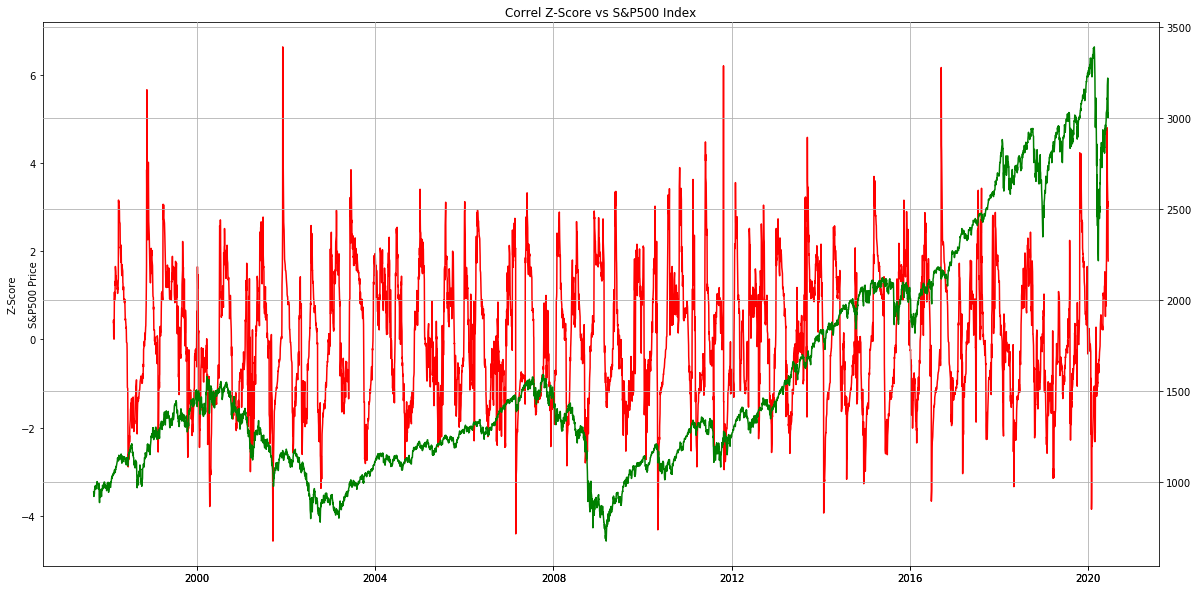

In [22]:
# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('Correlation Z-Score ')

# Generating the chart
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(Final_Market_Data_df['Date'],Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')


In [ ]:
# Plotting the S&P500

# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing Price'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('S&P500')

In [ ]:
Final_Market_Data_df

## 1997-2003

In [ ]:
ltcm_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='1997-09-09') & (Final_Market_Data_df['Date']<='2003-12-31')]
ltcm_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(ltcm_df['Date'],ltcm_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(ltcm_df['Date'],ltcm_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2004-2009

In [ ]:
financial_crisis_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2004-01-01') & (Final_Market_Data_df['Date']<='2009-12-31')]
financial_crisis_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(financial_crisis_df['Date'],financial_crisis_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(financial_crisis_df['Date'],financial_crisis_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2010-2015

In [ ]:
recovery_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2010-01-01') & (Final_Market_Data_df['Date']<='2015-12-31')]
recovery_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(recovery_df['Date'],recovery_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(recovery_df['Date'],recovery_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2016-2020

In [ ]:
latest_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2016-01-01') & (Final_Market_Data_df['Date']<='2020-06-11')]
latest_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(latest_df['Date'],latest_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(latest_df['Date'],latest_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## Yield Spread Ratio Analysis

In [23]:
Ratio_df = Final_Market_Data_df

In [24]:
# Calculate the Junk Bond to Treasury Yield Ratio
Ratio_df['Junk/Treasury'] = Ratio_df['B Rating'] / Ratio_df['5 Year Rate']

In [25]:
# Calculate the historical Volatilities of the ratio
vol_window = [21,55,100]
daily_vol = np.sqrt(252)

for vol in vol_window:
    Ratio_df[str(vol) + 'day vol'] = Ratio_df['Junk/Treasury'].rolling(vol).std()*daily_vol


In [26]:
print(daily_vol)
print(np.sqrt(252))

15.874507866387544
15.874507866387544


In [27]:
Ratio_df.head(100)

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,Junk/Treasury,21day vol,55day vol,100day vol
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN,1.536859,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN,1.530351,NaN,NaN,NaN
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN,1.531100,NaN,NaN,NaN
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN,1.552674,NaN,NaN,NaN
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN,1.547812,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1998-01-28,992.50,9.18,5.54,3.64,0.006848,0.005525,-0.262164,NaN,NaN,NaN,1.657040,0.723111,0.726165,NaN
96,1998-01-29,999.50,9.16,5.43,3.73,0.007053,0.024725,-0.233773,NaN,NaN,NaN,1.686924,0.689530,0.727156,NaN
97,1998-01-30,995.25,9.15,5.39,3.76,-0.004252,0.008043,-0.240230,NaN,NaN,NaN,1.697588,0.639561,0.729674,NaN
98,1998-02-02,1016.50,9.10,5.43,3.67,0.021351,-0.023936,-0.291509,NaN,NaN,NaN,1.675875,0.621423,0.726480,NaN


Text(0, 0.5, 'Yield Spread Returns')

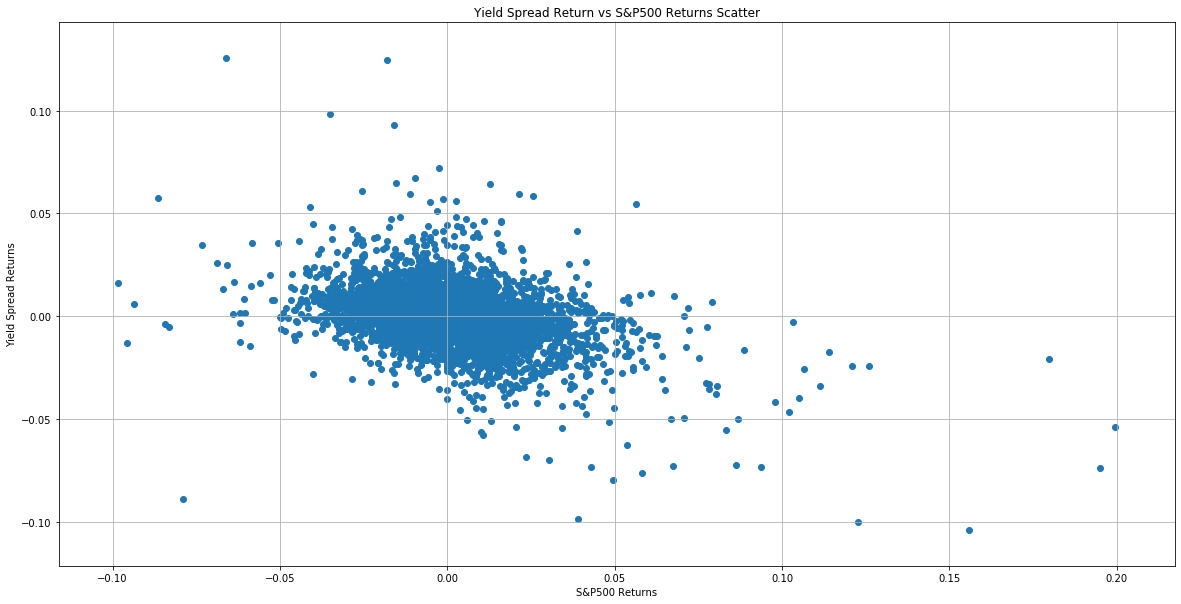

In [28]:
# Scatter Plot
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Yield Spread Returns'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Yield Spread Return vs S&P500 Returns Scatter')
plt.xlabel('S&P500 Returns')
plt.ylabel('Yield Spread Returns')

## Correlation S&P500 Returns vs Yield Spread Returns

In [40]:
# Correlation
x = Ratio_df['Yield Spread Returns'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

(-0.3794562404725583, 4.5237806171399184e-194)


## Linear Regression S&P500 Returns vs Yield Spread Returns

rvalue    = -0.379
r-squared = 0.144


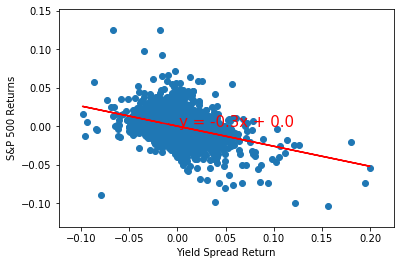

In [44]:
# Variables for the regression
x_values = Ratio_df['Yield Spread Returns'].dropna()
y_values = Ratio_df['S&P 500 Returns'].dropna()

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,1)) + "x + " + str(round(intercept,1))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.002, 0),fontsize=15,color="red")
plt.xlabel('Yield Spread Return')
plt.ylabel("S&P 500 Returns")

print(f"rvalue    = {round(rvalue, 3)}")
print(f"r-squared = {round(rvalue**2, 3)}")

plt.show()

In [ ]:
Ratio_df['S&P 500 Returns'].hist()

In [ ]:
Ratio_df['Yield Spread Returns'].hist()

In [ ]:
x = Ratio_df['Yield Spread']
x

In [ ]:
x.diff(periods=1)

## Adding Yield Spread Absolute Change

In [34]:
Ratio_df['Change in bps'] = Ratio_df['Yield Spread'].diff(periods=1)*100

In [35]:
Ratio_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,Junk/Treasury,21day vol,55day vol,100day vol,Change in bps
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN,1.536859,NaN,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN,1.530351,NaN,NaN,NaN,-3.0
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN,1.531100,NaN,NaN,NaN,1.0
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN,1.552674,NaN,NaN,NaN,8.0
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN,1.547812,NaN,NaN,NaN,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,2020-06-08,3216.75,5.99,0.45,5.54,0.012671,0.000000,-0.488649,0.062485,-0.683701,3.121583,13.311111,63.268123,55.706273,147.810453,0.0
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347,-0.472650,0.068124,-0.678796,3.026050,15.575000,65.271994,58.109162,146.414600,29.0
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875,-0.439552,0.074750,-0.673237,3.126240,19.212121,65.264248,54.998347,145.050575,18.0
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195,-0.526273,0.076836,-0.669455,1.863470,21.343750,64.463199,55.103583,143.778395,50.0


Text(0, 0.5, 'S&P 500 Returns')

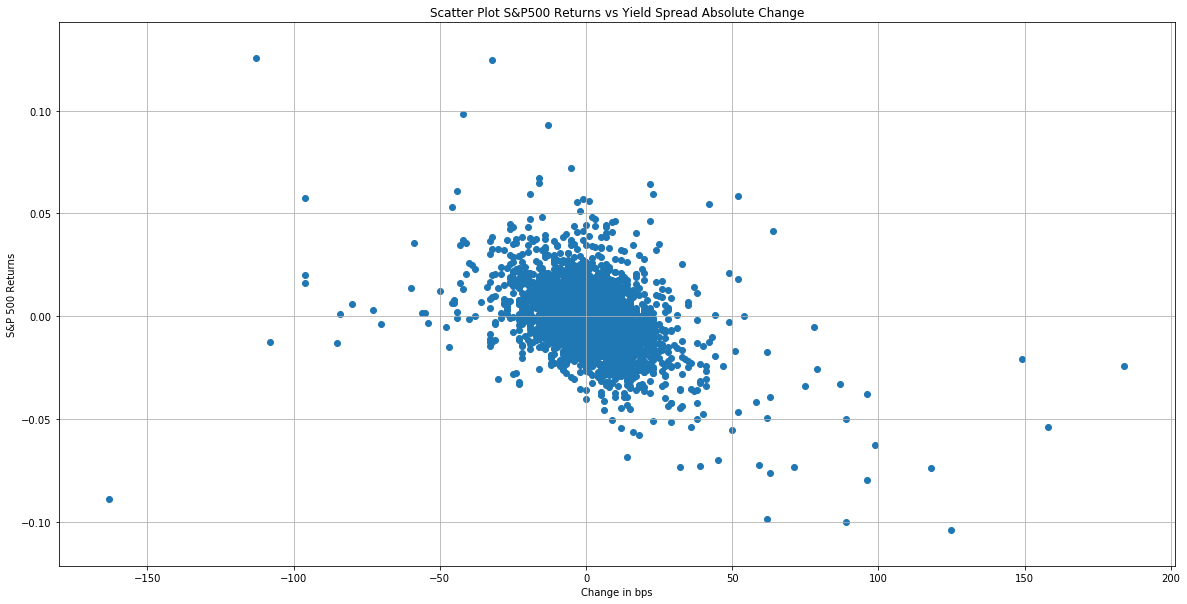

In [37]:
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Change in bps'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Scatter Plot S&P500 Returns vs Yield Spread Absolute Change')
plt.xlabel('Change in bps')
plt.ylabel('S&P 500 Returns')

In [43]:
# Correlation
x = Ratio_df['Change in bps'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

(-0.40025060599498635, 1.1033976961085055e-217)
